In [ ]:
import numpy as np 
import pandas as pd 
import os
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


image_dir = 'Data\Image'

image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('.jpg', '.png', '.jpeg'))]



mask_dir = 'Data\Mask'

mask_paths = [os.path.join(mask_dir, mask) for mask in os.listdir(mask_dir) if mask.endswith(('.jpg', '.png', '.jpeg'))]

Error loading image: Data\Image\0.jpg


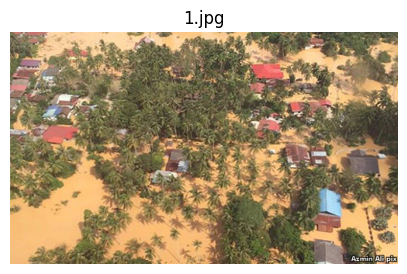

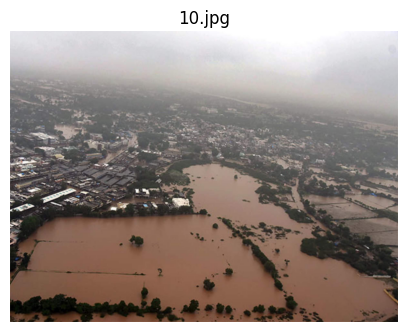

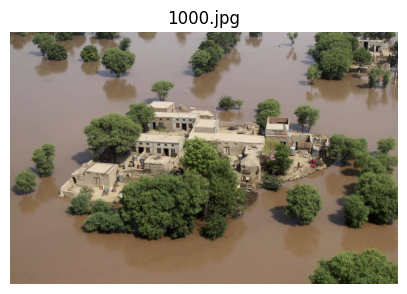

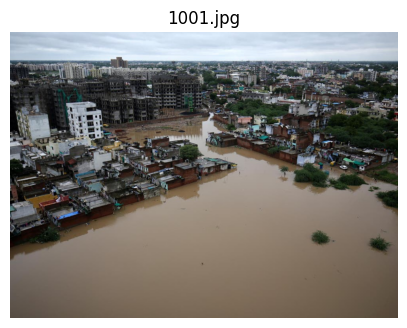

In [3]:
def display_images(image_paths,count):
    for i, image_path in enumerate(image_paths):
        image_name = os.path.basename(image_path)
        if count==i:
            break
        image = cv2.imread(image_path)

        if image is None:
            print(f"Error loading image: {image_path}")
            continue

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(5, 5))
        plt.imshow(image_rgb)
        plt.title(f"{image_name}")
        plt.axis('off')
        plt.show()

display_images(image_paths,5)

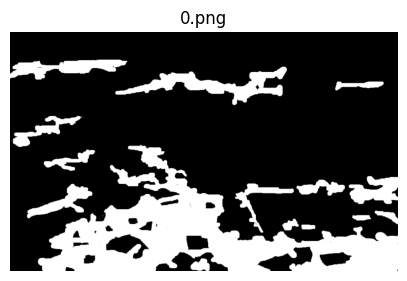

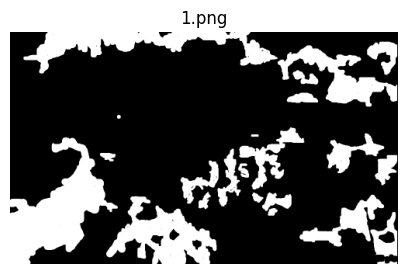

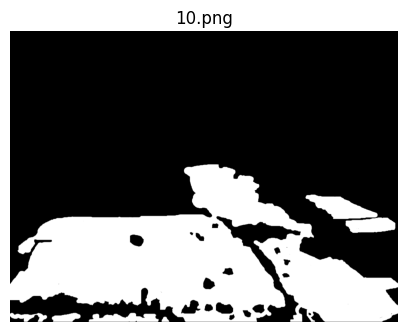

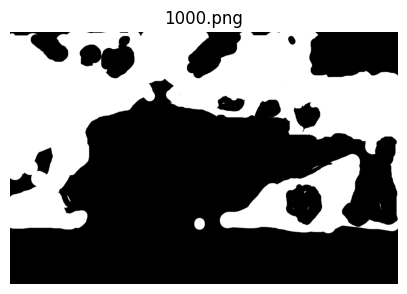

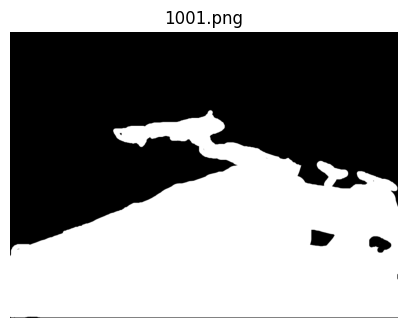

In [4]:
def display_masks(mask_paths, count):

    for i, mask_path in enumerate(mask_paths):
        mask_name = os.path.basename(mask_path)
        if i >= count:
            break
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) 

        if mask is None:
            print(f"Error loading mask: {mask_path}")
            continue

        plt.figure(figsize=(5, 5))
        plt.imshow(mask, cmap='gray')
        plt.title(f"{mask_name}")
        plt.axis('off')
        plt.show()

display_masks(mask_paths, 5)


In [5]:
def segment_image_kmeans(image_path, k=3):
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Error loading image: {image_path}")
        return None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    pixel_values = image_rgb.reshape((-1, 3))

    pixel_values = np.float32(pixel_values)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)

    segmented_image = centers[labels.flatten()]

    segmented_image = segmented_image.reshape(image_rgb.shape)

    return segmented_image

In [10]:
def save_segmented_image(segmented_image, original_image_path, output_folder="Data/SegmentedImages"):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    image_name = os.path.basename(original_image_path)
    save_path = os.path.join(output_folder,image_name)

    segmented_image_bgr = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(save_path, segmented_image_bgr)

    print(f"Segmented image saved at: {save_path}")

In [11]:
def segment_and_save_images(image_paths,k):
    for i, image_path in enumerate(image_paths):
        image_name = os.path.basename(image_path)

        segmented_image = segment_image_kmeans(image_path, k)

        if segmented_image is not None:
            save_segmented_image(segmented_image, image_path)
    

In [12]:
segment_and_save_images(image_paths,3)

Error loading image: Data\Image\0.jpg
Segmented image saved at: Data/SegmentedImages\1.jpg
Segmented image saved at: Data/SegmentedImages\10.jpg
Segmented image saved at: Data/SegmentedImages\1000.jpg
Segmented image saved at: Data/SegmentedImages\1001.jpg
Segmented image saved at: Data/SegmentedImages\1002.jpg
Segmented image saved at: Data/SegmentedImages\1003.jpg
Segmented image saved at: Data/SegmentedImages\1004.jpg
Segmented image saved at: Data/SegmentedImages\1005.jpg
Segmented image saved at: Data/SegmentedImages\1006.jpg
Segmented image saved at: Data/SegmentedImages\1007.jpg
Segmented image saved at: Data/SegmentedImages\1008.jpg
Segmented image saved at: Data/SegmentedImages\1009.jpg
Segmented image saved at: Data/SegmentedImages\1010.jpg
Segmented image saved at: Data/SegmentedImages\1011.jpg
Segmented image saved at: Data/SegmentedImages\1012.jpg
Segmented image saved at: Data/SegmentedImages\1013.jpg
Segmented image saved at: Data/SegmentedImages\1014.jpg
Segmented image

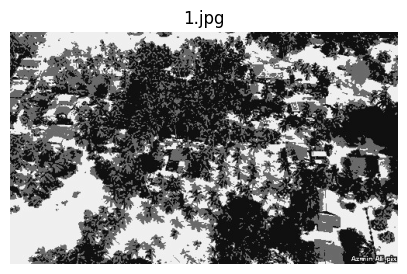

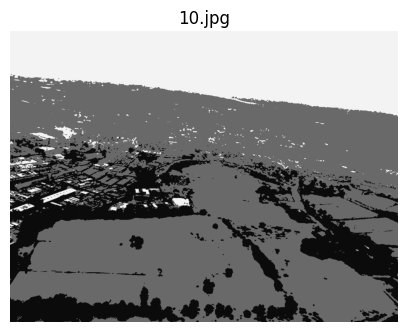

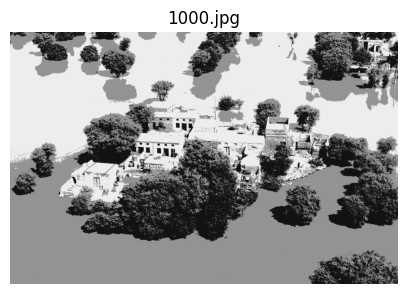

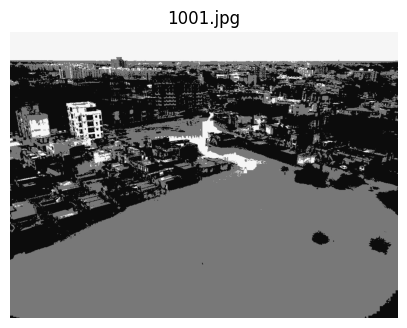

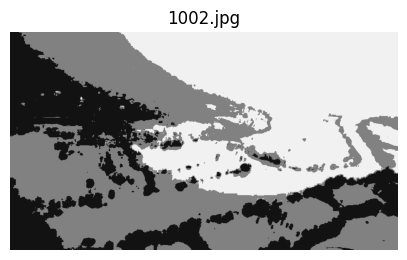

In [13]:
seg_dir = 'Data/SegmentedImages'

seg_paths = [os.path.join(seg_dir, seg) for seg in os.listdir(seg_dir) if seg.endswith(('.jpg', '.png', '.jpeg'))]

def display_segs(seg_paths, count):

    for i, seg_path in enumerate(seg_paths):
        seg_name = os.path.basename(seg_path)
        if i >= count:
            break
        seg = cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)  

        if seg is None:
            print(f"Error loading mask: {seg_path}")
            continue

        plt.figure(figsize=(5, 5))
        plt.imshow(seg, cmap='gray')
        plt.title(f"{seg_name}")
        plt.axis('off')
        plt.show()

display_segs(seg_paths, 5)

In [14]:
def calculate_iou(predicted_mask, ground_truth_mask):
    intersection = np.logical_and(predicted_mask, ground_truth_mask)
    union = np.logical_or(predicted_mask, ground_truth_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_dice(predicted_mask, ground_truth_mask):
    intersection = np.logical_and(predicted_mask, ground_truth_mask)
    dice_score = (2 * np.sum(intersection)) / (np.sum(predicted_mask) + np.sum(ground_truth_mask))
    return dice_score

def calculate_pixel_accuracy(predicted_mask, ground_truth_mask):
    correct = np.sum(predicted_mask == ground_truth_mask)
    total = predicted_mask.size
    accuracy = correct / total
    return accuracy

In [15]:
iou_scores = []
dice_scores = []
accuracies = []

for mask_filename in os.listdir(mask_dir):

    if not mask_filename.endswith(".png"):
        continue
    
    mask_path = os.path.join(mask_dir, mask_filename)
    
    segmented_filename = mask_filename.replace(".png", ".jpg")
    segmented_path = os.path.join(seg_dir, segmented_filename)
    
    if not os.path.exists(segmented_path):
        continue

    ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    segmented_image = cv2.imread(segmented_path, cv2.IMREAD_GRAYSCALE)
    segmented_image_resized = cv2.resize(segmented_image, (ground_truth_mask.shape[1], ground_truth_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    _, ground_truth_binary = cv2.threshold(ground_truth_mask, 127, 1, cv2.THRESH_BINARY)
    _, segmented_binary = cv2.threshold(segmented_image_resized, 127, 1, cv2.THRESH_BINARY)

    iou = calculate_iou(segmented_binary, ground_truth_binary)
    dice = calculate_dice(segmented_binary, ground_truth_binary)
    accuracy = calculate_pixel_accuracy(segmented_binary, ground_truth_binary)

    iou_scores.append(iou)
    dice_scores.append(dice)
    accuracies.append(accuracy)

In [16]:
avg_iou = np.mean(iou_scores)
avg_dice = np.mean(dice_scores)
avg_accuracy = np.mean(accuracies)

print("\nSummary of Results:")
print(f"Average IoU: {avg_iou:.4f}")
print(f"Average Dice Score: {avg_dice:.4f}")
print(f"Average Pixel Accuracy: {avg_accuracy:.4f}")


Summary of Results:
Average IoU: 0.4579
Average Dice Score: 0.5779
Average Pixel Accuracy: 0.6964


In [17]:
def segment_image_kmeans_with_pca(image_path, k=3, n_components=2):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return None
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixel_values = image_rgb.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    pca = PCA(n_components=n_components)
    reduced_pixels = pca.fit_transform(pixel_values)

    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=0)
    labels = kmeans.fit_predict(reduced_pixels)
    centers = kmeans.cluster_centers_

    centers = pca.inverse_transform(centers)
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image_rgb.shape)

    return segmented_image

In [18]:
iou_scores_pca = []
dice_scores_pca = []
accuracies_pca = []

for mask_filename in os.listdir(mask_dir):
    if not mask_filename.endswith(".png"):
        continue
    
    mask_path = os.path.join(mask_dir, mask_filename)
    segmented_path = os.path.join(seg_dir, mask_filename.replace(".png", ".jpg"))
    
    if not os.path.exists(segmented_path):
        continue
    
    ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    segmented_image_pca = segment_image_kmeans_with_pca(segmented_path, k=3, n_components=2)
    
    if segmented_image_pca is None:
        continue
    
    segmented_gray_pca = cv2.cvtColor(segmented_image_pca, cv2.COLOR_RGB2GRAY)
    _, segmented_binary_pca = cv2.threshold(segmented_gray_pca, 127, 1, cv2.THRESH_BINARY)
    _, ground_truth_binary = cv2.threshold(ground_truth_mask, 127, 1, cv2.THRESH_BINARY)
    
    segmented_binary_pca_resized = cv2.resize(segmented_binary_pca, 
                                          (ground_truth_binary.shape[1], ground_truth_binary.shape[0]), 
                                          interpolation=cv2.INTER_NEAREST)

    iou_pca = calculate_iou(segmented_binary_pca_resized, ground_truth_binary)
    dice_pca = calculate_dice(segmented_binary_pca_resized, ground_truth_binary)
    accuracy_pca = calculate_pixel_accuracy(segmented_binary_pca_resized, ground_truth_binary)
    
    iou_scores_pca.append(iou_pca)
    dice_scores_pca.append(dice_pca)
    accuracies_pca.append(accuracy_pca)

In [19]:
avg_iou_pca = np.mean(iou_scores_pca)
avg_dice_pca = np.mean(dice_scores_pca)
avg_accuracy_pca = np.mean(accuracies_pca)

print("\nSummary of Results with PCA:")
print(f"Average IoU (with PCA): {avg_iou_pca:.4f}")
print(f"Average Dice Score (with PCA): {avg_dice_pca:.4f}")
print(f"Average Pixel Accuracy (with PCA): {avg_accuracy_pca:.4f}")


Summary of Results with PCA:
Average IoU (with PCA): 0.4577
Average Dice Score (with PCA): 0.5774
Average Pixel Accuracy (with PCA): 0.6959


In [20]:
avg_metrics_original = [np.mean(iou_scores), np.mean(dice_scores), np.mean(accuracies)]
avg_metrics_pca = [np.mean(iou_scores_pca), np.mean(dice_scores_pca), np.mean(accuracies_pca)]
metrics_labels = ["IoU", "Dice Score", "Pixel Accuracy"]

In [23]:
fig = go.Figure()

fig.add_trace(go.Line(
    x=metrics_labels,
    y=avg_metrics_original,
    name='Original Segmentation',
    marker_color='black'
))

fig.add_trace(go.Bar(
    x=metrics_labels,
    y=avg_metrics_pca,
    name='PCA Segmentation',
    marker_color='red'
))

fig.update_layout(
    title="Average Performance Comparison between Original and PCA Segmentation",
    xaxis_title="Metrics",
    yaxis_title="Average Score",
    barmode='group',
    height=500
)

fig.show()

c:\Users\ASUS\miniconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [26]:

iou_decrease_percent = ((avg_iou - avg_iou_pca) / avg_iou) * 100
dice_decrease_percent = ((avg_dice - avg_dice_pca) / avg_dice) * 100
accuracy_decrease_percent = ((avg_accuracy - avg_accuracy_pca) / avg_accuracy) * 100

metrics = ['IoU', 'Dice', 'Accuracy']
decreases = [iou_decrease_percent, dice_decrease_percent, accuracy_decrease_percent]

fig = go.Figure(go.Bar(
    x=metrics,
    y=decreases,
    marker_color='indianred',
    text=[f"{val:.2f}%" for val in decreases],  
    textposition='auto'
))

fig.update_layout(
    title="Percentage Decrease in Metrics after PCA",
    xaxis_title="Metrics",
    yaxis_title="Decrease (%)",
    yaxis=dict(ticksuffix="%"),
    template="plotly_white"
)

fig.show()
